# **Part 1: EDA**

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import Image

## General observations

We will use the file containing the train values, and keep the test file for validating our model at the end.

In [2]:
data = pd.read_csv('Data/conversion_data_train.csv')
print('Number of rows / columns :', data.shape)

Number of rows / columns : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [4]:
display(data.describe(include = 'all'))

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


The target variable is "converted", which is categorial and takes 2 values: 0 and 1. 
There are 5 explanative variables: 3 categorical ("country" taking 4 values, "new_user" taking 2 values, and "source" taking 3 values) and 2 numerical ("age" from 17 to 123 years old and "total_pages_visited" from 1 to 29 pages). Let's remove ages above 100 years old, which seems quite weird.

In [5]:
data = data[data['age'] <= 100]

In [6]:
display(100*data.isnull().sum()/data.shape[0])

country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

No missing values.

In [7]:
data['converted'].value_counts()

0    275400
1      9178
Name: converted, dtype: int64

## Target variable

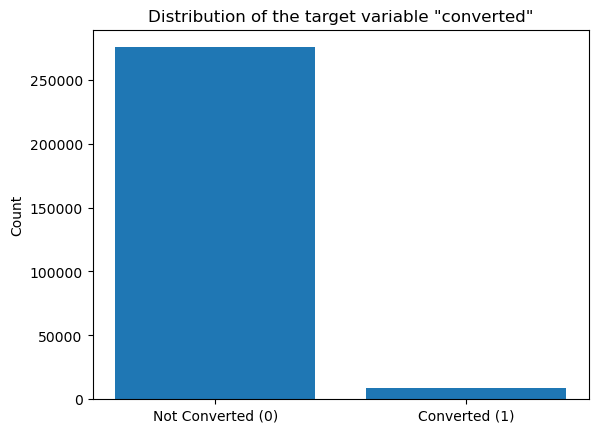

In [8]:
plt.bar(['Not Converted (0)', 'Converted (1)'], data['converted'].value_counts())
plt.title('Distribution of the target variable "converted"')
plt.ylabel('Count')
plt.show()

The target variable "converted" is not well distributed between 0 and 1. We will have to pay attention to use stratify when defining the train and val.

## Numerical features

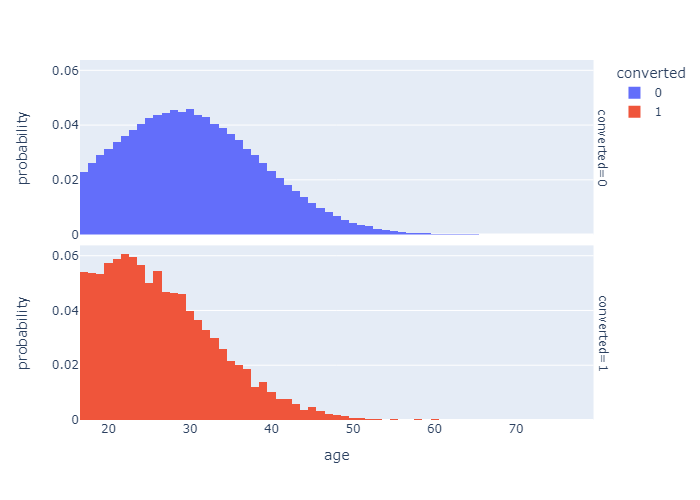

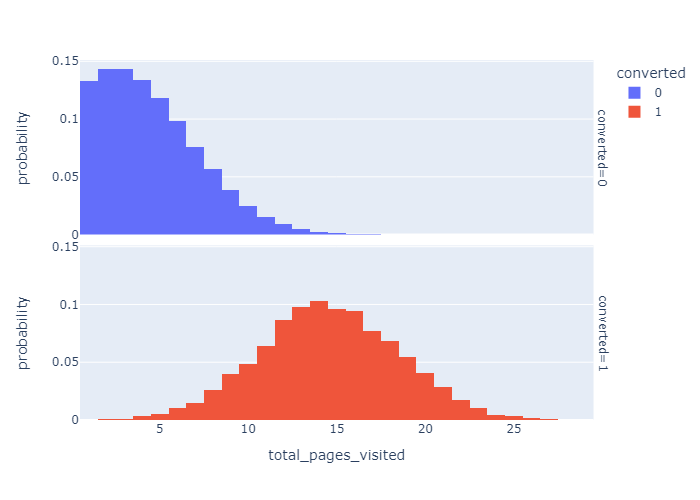

In [16]:
num_features = ['age','total_pages_visited']

for feature in num_features:
    fig = px.histogram(data, feature, color = 'converted', facet_row = 'converted', histnorm = 'probability')
    # fig.show()
    # Save the figure as a static image in order to see it in github
    pio.write_image(fig, f'Graphs/{feature} distribution.png')
    display(Image(filename=f'Graphs/{feature} distribution.png'))

We already observe a tendency that people who suscribe are a bit younger in general that people who don't, and that the number of pages visited before suscription is elevated (approximateky 10 to 20) whereas people who don't suscribe usually don't hesitate, they just visit less than 5-10 times the website.

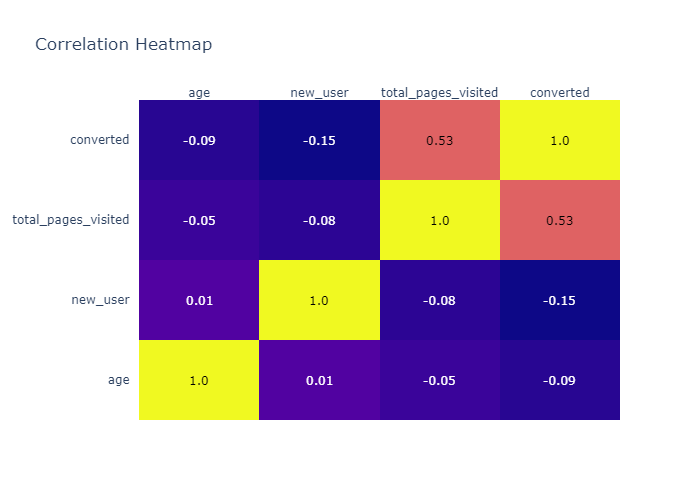

In [10]:
corr_matrix = data.corr().round(2)

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist(),
                                  )
fig.update_layout(title_text='Correlation Heatmap')
# fig.show()

# Save the figure as a static image in order to see it in github
pio.write_image(fig, f'Graphs/Correlation Heatmap.png')
display(Image(filename=f'Graphs/Correlation Heatmap.png'))

It seems that there is no pairwise dependencies between numerical variables and that the total_pages_visited is highly correlated with our target variable converted.

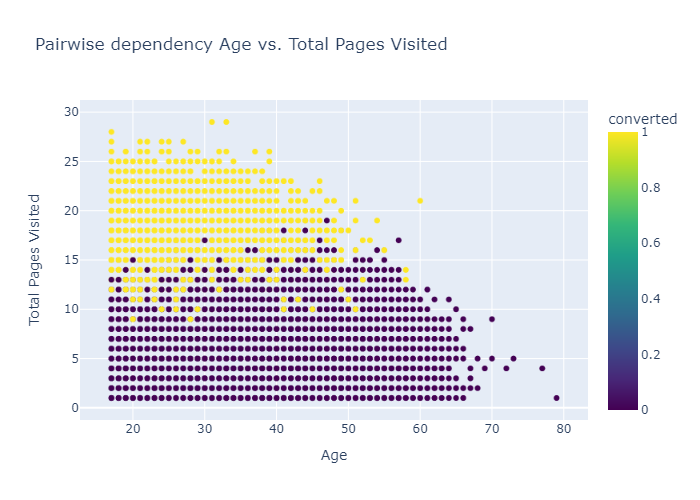

In [11]:
fig = px.scatter(data, x='age', y='total_pages_visited', color='converted',
                 color_continuous_scale='Viridis', hover_data=['converted'],
                 labels={'age': 'Age', 'total_pages_visited': 'Total Pages Visited'},
                 title='Pairwise dependency Age vs. Total Pages Visited')
# fig.show()

# Save the figure as a static image in order to see it in github
pio.write_image(fig, 'Graphs/Age_vs_TotalPagesVisited.png')
Image(filename='Graphs/Age_vs_TotalPagesVisited.png')

## Categorical features

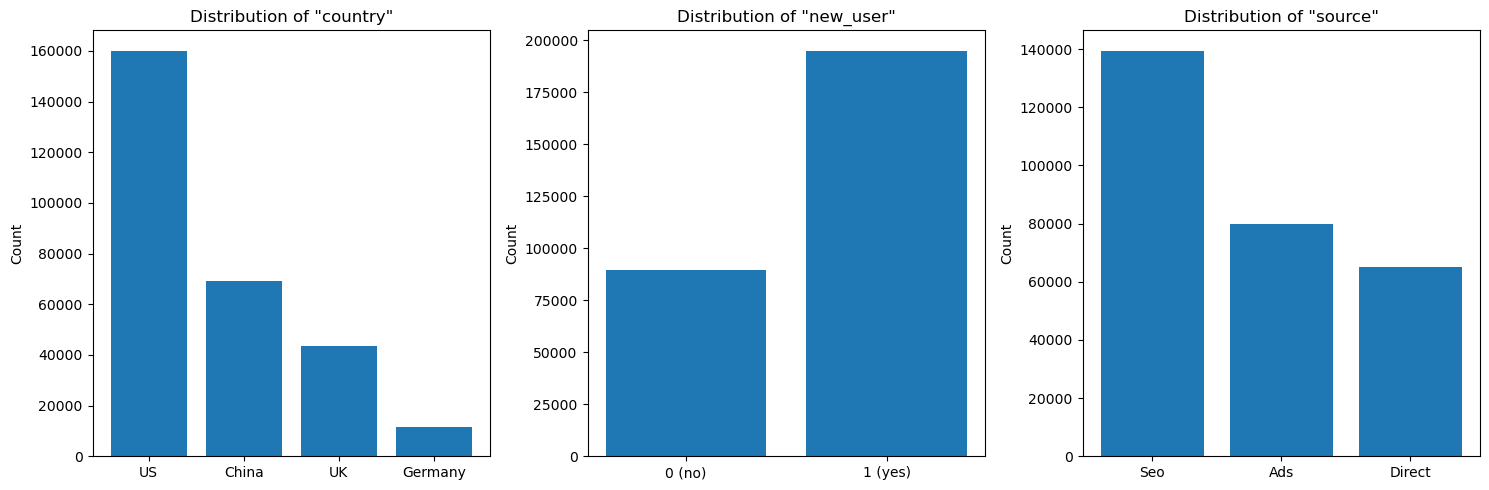

In [12]:
cat_features = ['country','new_user','source']

fig, axs = plt.subplots(1, len(cat_features), figsize=(15, 5))

for i, feature in enumerate(cat_features):
    counts = data[feature].value_counts()
    axs[i].bar(counts.index, counts.values)
    axs[i].set_title(f'Distribution of "{feature}"')
    axs[i].set_ylabel('Count')
    
    if feature == 'new_user':
        axs[i].set_xticks([0, 1])
        axs[i].set_xticklabels(['0 (no)', '1 (yes)'])

plt.tight_layout()
plt.show()


We see that most people in the pole are from US, generally more a new user, and the source is mostly Seo.

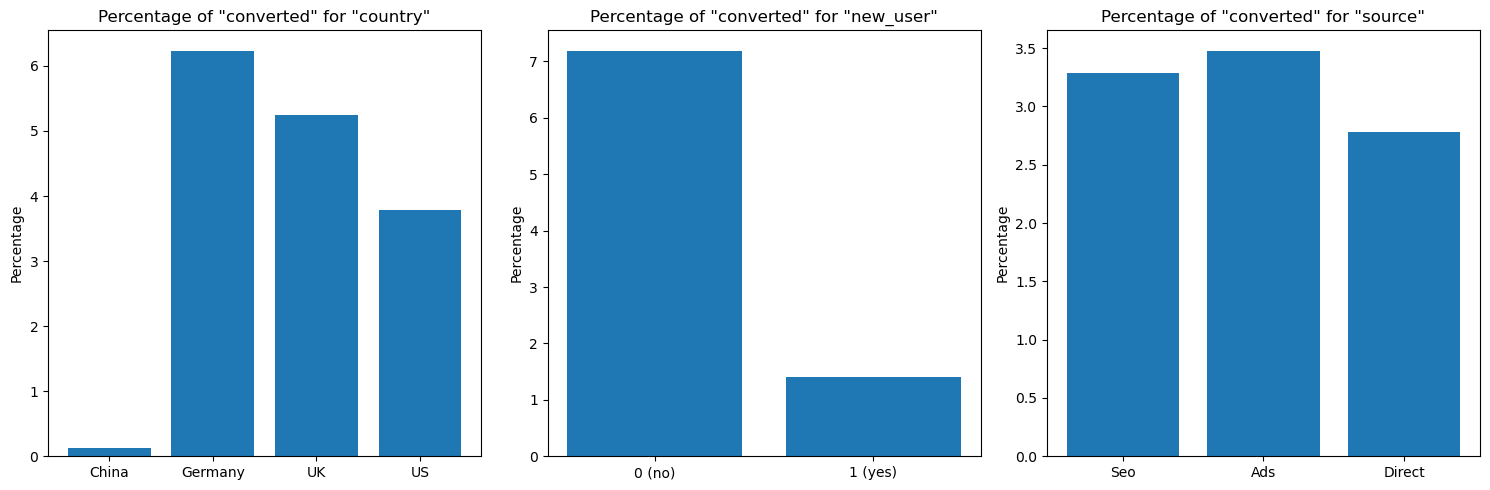

In [17]:
fig, axs = plt.subplots(1, len(cat_features), figsize=(15, 5))

for i, feature in enumerate(cat_features):
    counts = data[feature].value_counts()
    converted_counts = data[data['converted'] == 1][feature].value_counts()
    percentages = (converted_counts / counts) * 100
    
    axs[i].bar(percentages.index, percentages.values)
    axs[i].set_title(f'Percentage of "converted" for "{feature}"')
    axs[i].set_ylabel('Percentage')
    
    if feature == 'new_user':
        axs[i].set_xticks([0, 1])
        axs[i].set_xticklabels(['0 (no)', '1 (yes)'])

plt.tight_layout()
plt.show()


It seems that the country makes a big difference on suscription or not (germans suscribe a lot, chinese not at all). New users (1) do not suscribe a lot, whereas users not new (0) suscribe much more, which makes sense knowing that the more pages visited the more there is a chance that the user suscribed. Finally, the source doesn't seem to impact subscription at all.